In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from fis_cleaning_functions import *

In [2]:
with open("data/fis_dataframe.pkl","rb") as picklefile:
    df = pickle.load(picklefile)

In [3]:
# drop_duplicates was called before pickeling
if len(df) != df.index[-1]:
    df.reset_index(inplace=True)
print("Length equals last index:",len(df)==df.index[-1]+1)

Length equals last index: True


In [27]:
df["datetime"]= pd.to_datetime(df["date"])
df["season"] = df["datetime"].transform(get_season)
df.rename(axis=1, mapper={"ladies":"gender:ladies"}, inplace=True)

first_days = df.groupby("season")["datetime"].min()
df["days_since_season_start"] = [get_day_of_season(date, first_days) for date in df["datetime"]]

df["ski_field"]=df["location"].transform(standardize_location)
df["region"]=[get_region(field) for field in df["ski_field"]]

# Cheating: stealing from the future. but may be interesting.
df["median_finish_time"]=df["finish_times"].transform(lambda x: x[int(len(x)/2)])
df["normalized_times"]=df["finish_times"].transform(np.array)/df["median_finish_time"]
df["normalized_time_stdev"]=[np.std(row["normalized_times"]) for _, row in df.iterrows()]


df["sqrt_dnf_rate"] = df["dnf_rate"].transform(lambda x: np.sqrt(x+np.e**-5.5))
df["olympics"] = [is_olympics(row) for _, row in df.iterrows()]

In [28]:
if "index" in df.columns:
    df.drop("index", axis=1, inplace=True)
df.head()

,dnf_rate,location,gender:ladies,event,date,finish_times,datetime,season,days_since_season_start,ski_field,region,median_finish_time,normalized_times,normalized_time_stdev,log_dnf_rate,olympics,sqrt_dnf_rate
0,0.043478,Are (SWE),True,Slalom,17 March 2018,"[106.42, 108.0, 108.00999999999999, 108.14, 10...",2018-03-17,2018,140,Are (SWE),NEUTRAL,109.36,"[0.9731163130943673, 0.9875640087783467, 0.987...",0.013171,-3.045657,False,0.218094
1,0.086957,Are (SWE),False,Giant Slalom,17 March 2018,"[133.63, 133.86, 133.89, 134.31, 134.73, 135.2...",2018-03-17,2018,140,Are (SWE),NEUTRAL,135.74,"[0.9844555768380727, 0.9861499926329749, 0.986...",0.008364,-2.396420,False,0.301734
2,0.106383,Are (SWE),True,Super G,15 March 2018,"[67.92, 68.24, 68.45, 68.67, 68.85, 69.0, 69.0...",2018-03-15,2018,138,Are (SWE),NEUTRAL,69.42,"[0.9783923941227312, 0.9830020167098817, 0.986...",0.008501,-2.203014,False,0.332370
3,0.000000,Are (SWE),False,Super G,15 March 2018,"[49.43, 49.47, 49.51, 49.51, 49.58, 49.62, 49....",2018-03-15,2018,138,Are (SWE),NEUTRAL,49.89,"[0.9907797153738224, 0.9915814792543596, 0.992...",0.007044,-5.500000,False,0.063928
4,0.020408,Are (SWE),False,Downhill,14 March 2018,"[80.21000000000001, 80.21000000000001, 80.25, ...",2018-03-14,2018,137,Are (SWE),NEUTRAL,80.91,"[0.9913484118155977, 0.9913484118155977, 0.991...",0.005759,-3.709289,False,0.156509


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 17 columns):
dnf_rate                   737 non-null float64
location                   737 non-null object
gender:ladies              737 non-null bool
event                      737 non-null object
date                       737 non-null object
finish_times               737 non-null object
datetime                   737 non-null datetime64[ns]
season                     737 non-null int64
days_since_season_start    737 non-null int64
ski_field                  737 non-null object
region                     737 non-null object
median_finish_time         737 non-null float64
normalized_times           737 non-null object
normalized_time_stdev      737 non-null float64
log_dnf_rate               737 non-null float64
olympics                   737 non-null bool
sqrt_dnf_rate              737 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(5), int64(2), object(7)
memory usage: 87.9+ K

In [30]:
event_dummies = pd.get_dummies(df["event"], drop_first=True)
event_dummies.rename(lambda s: "event:"+s, axis=1, inplace=True)

region_dummies = pd.get_dummies(df["region"], drop_first=True)
region_dummies.rename(lambda s: "region:"+s, axis=1, inplace=True)

dummied_df = df.join(event_dummies).join(region_dummies)

In [32]:
dummied_df.corr()

,dnf_rate,gender:ladies,season,days_since_season_start,median_finish_time,normalized_time_stdev,log_dnf_rate,olympics,sqrt_dnf_rate,event:Downhill,...,event:Super G,region:BUL,region:CAN,region:FRA,region:GER,region:ITA,region:KOR,region:NEUTRAL,region:NOR,region:SE_ALPS
dnf_rate,1.000000,-0.127563,0.024339,-0.150628,0.286839,0.161316,0.854186,-0.026058,0.972492,-0.562793,...,-0.218931,-0.044759,-0.218057,-0.035917,-0.053886,-0.077535,-0.064810,0.036532,-0.144073,0.297075
gender:ladies,-0.127563,1.000000,0.023228,-0.018580,-0.175880,-0.062313,-0.072118,0.012146,-0.103590,-0.041544,...,0.060233,-0.011468,0.069757,0.007953,0.053809,-0.029455,0.003589,0.001566,-0.170946,-0.004295
season,0.024339,0.023228,1.000000,-0.012940,-0.145572,-0.013376,0.058916,-0.006854,0.040032,0.004762,...,0.025938,-0.058019,-0.096407,0.004693,-0.095518,0.040279,0.194312,0.071761,-0.003498,-0.042646
days_since_season_start,-0.150628,-0.018580,-0.012940,1.000000,-0.090779,0.179831,-0.126659,0.159697,-0.148723,0.032743,...,0.056155,0.100955,-0.242586,-0.106569,0.230730,-0.125774,0.101911,0.037354,0.211473,-0.022790
median_finish_time,0.286839,-0.175880,-0.145572,-0.090779,1.000000,0.036304,0.309156,0.032202,0.313512,-0.148137,...,-0.568626,-0.035399,-0.102876,-0.020883,0.021933,-0.051360,-0.052820,0.033004,-0.103744,0.142405
normalized_time_stdev,0.161316,-0.062313,-0.013376,0.179831,0.036304,1.000000,0.123859,0.138620,0.147448,-0.139290,...,-0.062384,-0.013331,-0.024012,-0.059154,0.094568,-0.080750,0.061156,0.049070,-0.055118,0.007706
log_dnf_rate,0.854186,-0.072118,0.058916,-0.126659,0.309156,0.123859,1.000000,-0.059381,0.948527,-0.575886,...,-0.135596,-0.062681,-0.198280,-0.069628,0.013988,-0.048836,-0.103080,0.038620,-0.092039,0.239753
olympics,-0.026058,0.012146,-0.006854,0.159697,0.032202,0.138620,-0.059381,1.000000,-0.036341,0.041303,...,-0.011674,-0.021201,0.216078,-0.066766,-0.061484,-0.077130,0.450480,0.008654,-0.037978,-0.123078
sqrt_dnf_rate,0.972492,-0.103590,0.040032,-0.148723,0.313512,0.147448,0.948527,-0.036341,1.000000,-0.600193,...,-0.187984,-0.052055,-0.224389,-0.051803,-0.025804,-0.070536,-0.081973,0.046580,-0.135216,0.282087
event:Downhill,-0.562793,-0.041544,0.004762,0.032743,-0.148137,-0.139290,-0.575886,0.041303,-0.600193,1.000000,...,-0.313796,-0.060787,0.174072,0.034390,0.054175,0.094955,0.046712,-0.080608,0.104639,-0.176680


## Correlations

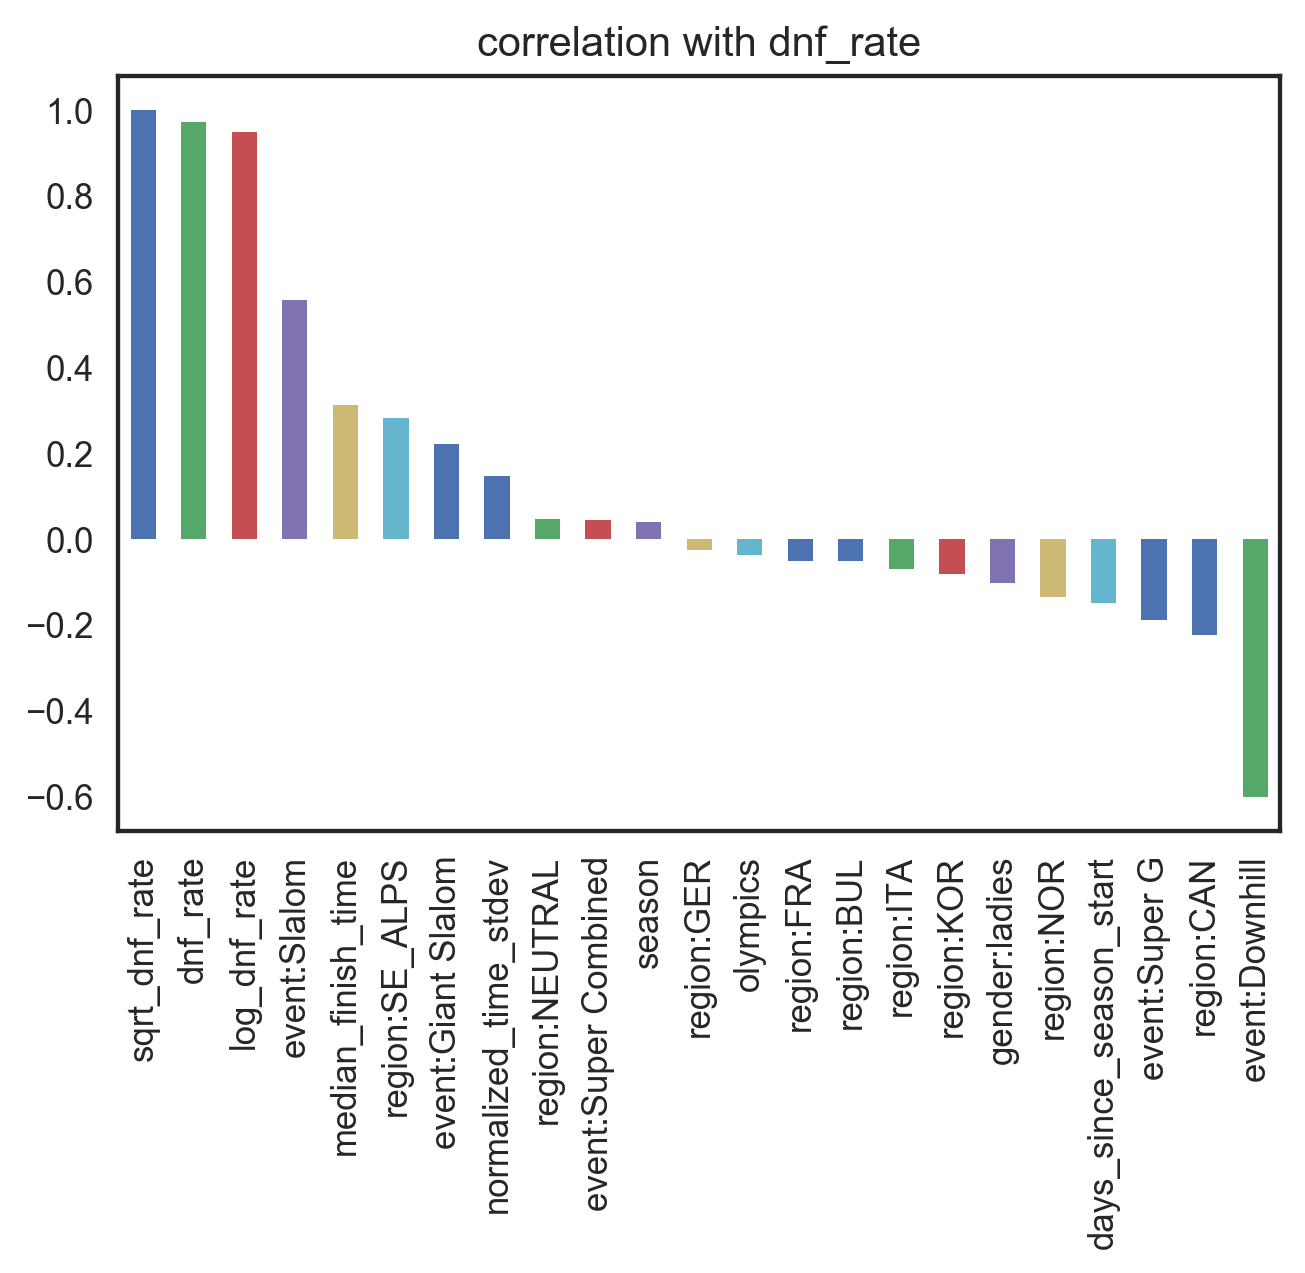

In [33]:
plt.figure(dpi=250)
dummied_df.corr()["sqrt_dnf_rate"].sort_values(ascending=False).plot(kind="bar")
plt.title("correlation with dnf_rate");

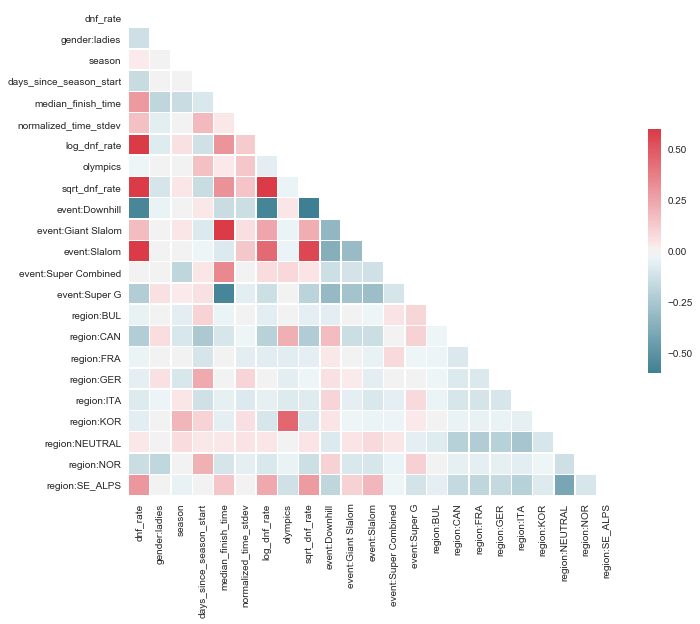

In [34]:
sns.set(style="white")


# Compute the correlation matrix
corr = dummied_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# modelling


In [263]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures


%matplotlib inline

Manually write a `test_train_split` ~~because you can't find the real one~~ for random-state reproducibility.

(turns out, works well for separating my supertesting set)

In [39]:
shuffled_df = dummied_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_thresh = int(0.2*len(shuffled_df))
supertest_df = shuffled_df.iloc[:test_thresh]
train_df = shuffled_df.iloc[test_thresh:]

#print("Testing samples:",len(test_df),"\nTraining samples:",len(train_df))

In [41]:
import pickle
import time

with open("data/test_df_{}.pkl".format(time.strftime("%Y%m%d-%H%M")), "wb") as picklefile:
    pickle.dump(supertest_df, picklefile)

with open("data/train_df_{}.pkl".format(time.strftime("%Y%m%d-%H%M")), "wb") as picklefile:
    pickle.dump(train_df, picklefile)
print(time.strftime("%Y%m%d-%H%M"))


20180425-1926


Make column masks to quickly grab `target` and `features` from a `DataFrame`

In [40]:
target1="sqrt_dnf_rate"
target0="dnf_rate"
features = (["gender:ladies","days_since_season_start","olympics"]+ 
            list(event_dummies.columns) +
            list(region_dummies.columns))
#features

In [293]:
import pickle
with open ("data/train_df_20180425-1926.pkl", "rb") as picklefile:
    train_df = pickle.load(picklefile)

Use the real `test_train_split`

In [294]:
rand_state = np.random.randint(2048)


X_train, X_test, y_train0, y_test0 = \
    train_test_split(train_df[features], train_df[target0], test_size=0.2, random_state=rand_state)
_, _, y_train1, y_test1 = \
    train_test_split(train_df[features], train_df[target1], test_size=0.2, random_state=rand_state)
    
y_trains = [y_train0, y_train1]
y_tests = [y_test0, y_test1]

In [295]:
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [296]:
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)


```python
ssX = StandardScaler()

X = df_movie_dropt[[x for x in df_movie_dropt.columns if x!='adj_revenue_log']]
y = df_movie_dropt['adj_revenue_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)
```

In [297]:
for t in [0,1]:
    lr = LinearRegression()
    lr.fit(X_train, y_trains[t])
    print(lr.score(X_test, y_tests[t]))

-21518570278973.9
-8259078774197.153


In [298]:
for t in [0,1]:
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_trains[t])
    print(lr.score(X_test_scaled, y_tests[t]))

-3.0972002561066376e+25
-1.6455690037459078e+26


**basic target statistics**

In [299]:
print("target mean:",df[target].mean())
print("target stdev:",df[target].std())

target mean: 0.35116675425387706
target stdev: 0.15335970179799335


In [300]:
linear_model = LinearRegression()
linear_model.fit(train_df[features],train_df[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Regularization

From class lecture

```python
# Bringing in our helper functions

def f(x):
    return np.sin(2 * np.pi * x)

def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

x_plot = np.linspace(0, 1, 100)

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))
```

In [301]:
def run_model(model, Xtrain, Xtest, t):
    model.fit(Xtrain, y_trains[t])
    print("Score: ",model.score(Xtest, y_tests[t]))
    plot_residuals(model, Xtest, t)
    
def plot_residuals(model, xtest, t):
    y_hat = model.predict(xtest)
    error = (y_hat - y_tests[t])
    plt.plot(y_hat, error, "o")

In [302]:
plt.style.use("fivethirtyeight")
xtrains = [X_train, X_train_scaled]
xtests = [X_test, X_test_scaled]

Default0
Score:  0.5671031435353218
Default1
Score:  0.552849943425232
SScaled0


/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Score:  0.6412329911196728
SScaled1


/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Score:  0.6241767360992907


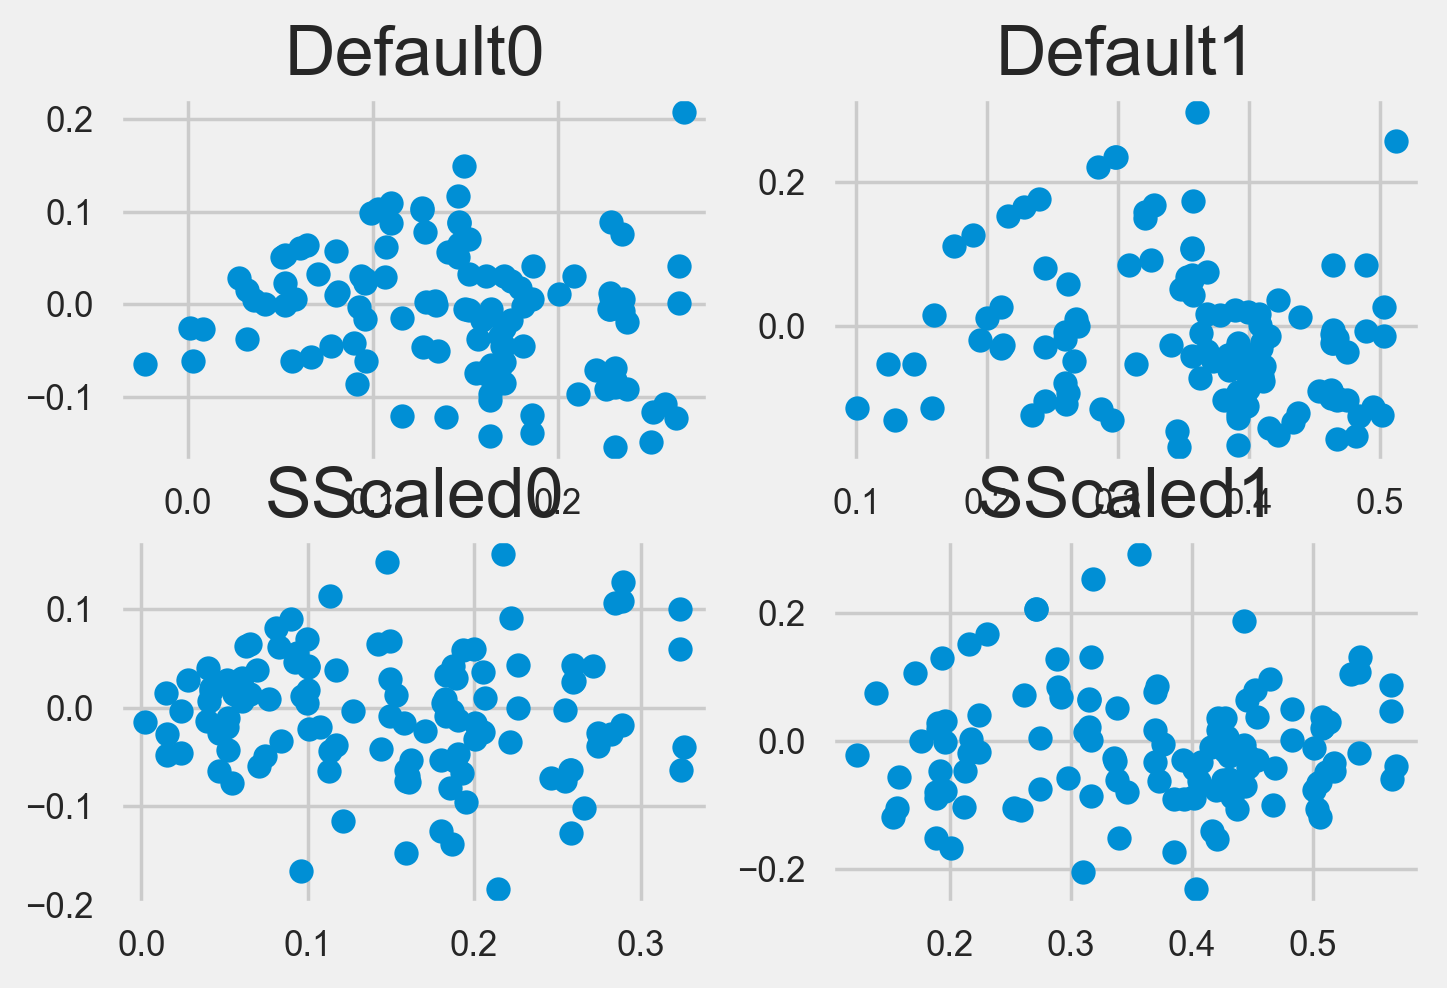

In [303]:
plt.figure(dpi=250)
xtitles = ["Default","SScaled"]
for i in range(4):
    plt.subplot(2,2,i+1)
    print(xtitles[i//2]+str(i%2))
    plt.title(xtitles[i//2]+str(i%2))
    run_model(lcv,xtrains[i//2],xtests[i//2],(i%2))
    

In [306]:
model=Lasso(max_iter=50)
parameters = {"alpha": [1,0.1], "fit_intercept":[False]}
grid = GridSearchCV(model,parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=3, return_train_score=True)
grid.fit(X_train_scaled, y_train0)

KeyboardInterrupt: 

In [347]:
lcv0 = Lasso(max_iter=20000000,alpha=0.0036,fit_intercept=True)
lcv0.fit(X_train_scaled,y_train0)
lcv0.score(X_test_scaled,y_test0)

0.6615509013255907

In [352]:
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(features,p) for p in poly.powers_]]

In [357]:
print(len(target_feature_names))
print(len(lcv0.coef_))

coefs = zip(target_feature_names, lcv0.coef_)
coefs = sorted(coefs, key=(lambda x:abs(x[1])),reverse=True)
for c in coefs:
    print(c)

171
171
('event:Slalom^1', 0.04139540044301016)
('event:Downhill^1', -0.03886310728099469)
('gender:ladies^1xevent:Slalom^1', -0.01231170117047865)
('days_since_season_start^2', -0.011981244297940648)
('event:Slalom^1xregion:SE_ALPS^1', 0.011671326921970085)
('event:Giant Slalom^1', 0.010595905490916678)
('event:Super G^1', -0.009924742966351584)
('event:Slalom^2', 0.0057614445534406)
('gender:ladies^1xdays_since_season_start^1', -0.005332106804633901)
('region:CAN^1', -0.003909911911563925)
('event:Giant Slalom^2', 0.0031164459254945077)
('event:Giant Slalom^1xregion:ITA^1', 0.0026340308878495334)
('event:Super G^1xregion:KOR^1', -0.00223899398694845)
('days_since_season_start^1xregion:SE_ALPS^1', 0.0021775668778881135)
('event:Downhill^1xregion:GER^1', 0.0018927794796225565)
('event:Super G^1xregion:BUL^1', -0.0018438489763193144)
('olympics^1xregion:NEUTRAL^1', 0.001725458665476746)
('region:CAN^2', -0.0015826683386807128)
('event:Super G^1xregion:ITA^1', -0.00144808294346535)
('day

In [305]:
X_train_scaled.shape

(472, 171)

In [205]:
grid.cv_results_

{'mean_fit_time': array([0.00172014, 0.00118995, 0.00058322, 0.00049753, 0.00047307,
        0.00040922]),
 'mean_score_time': array([0.00041041, 0.00021219, 0.00018959, 0.00018563, 0.00017705,
        0.00018077]),
 'mean_test_score': array([-0.05168033, -0.14128088, -0.05161365, -0.14055017, -0.06157859,
        -0.13892394]),
 'mean_train_score': array([-0.04919288, -0.13733766, -0.04964907, -0.13756947, -0.06069957,
        -0.13773934]),
 'param_alpha': masked_array(data=[0.0002, 0.0002, 0.002, 0.002, 0.02, 0.02],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, False, True, False, True, False],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0002, 'fit_intercept': True},
  {'alpha': 0.0002, 'fit_intercept': False},
  {'alpha': 0.002, 'fit_intercept': True},
  {'alpha': 0.002, '

In [206]:
grid.best_params_

{'alpha': 0.002, 'fit_intercept': True}

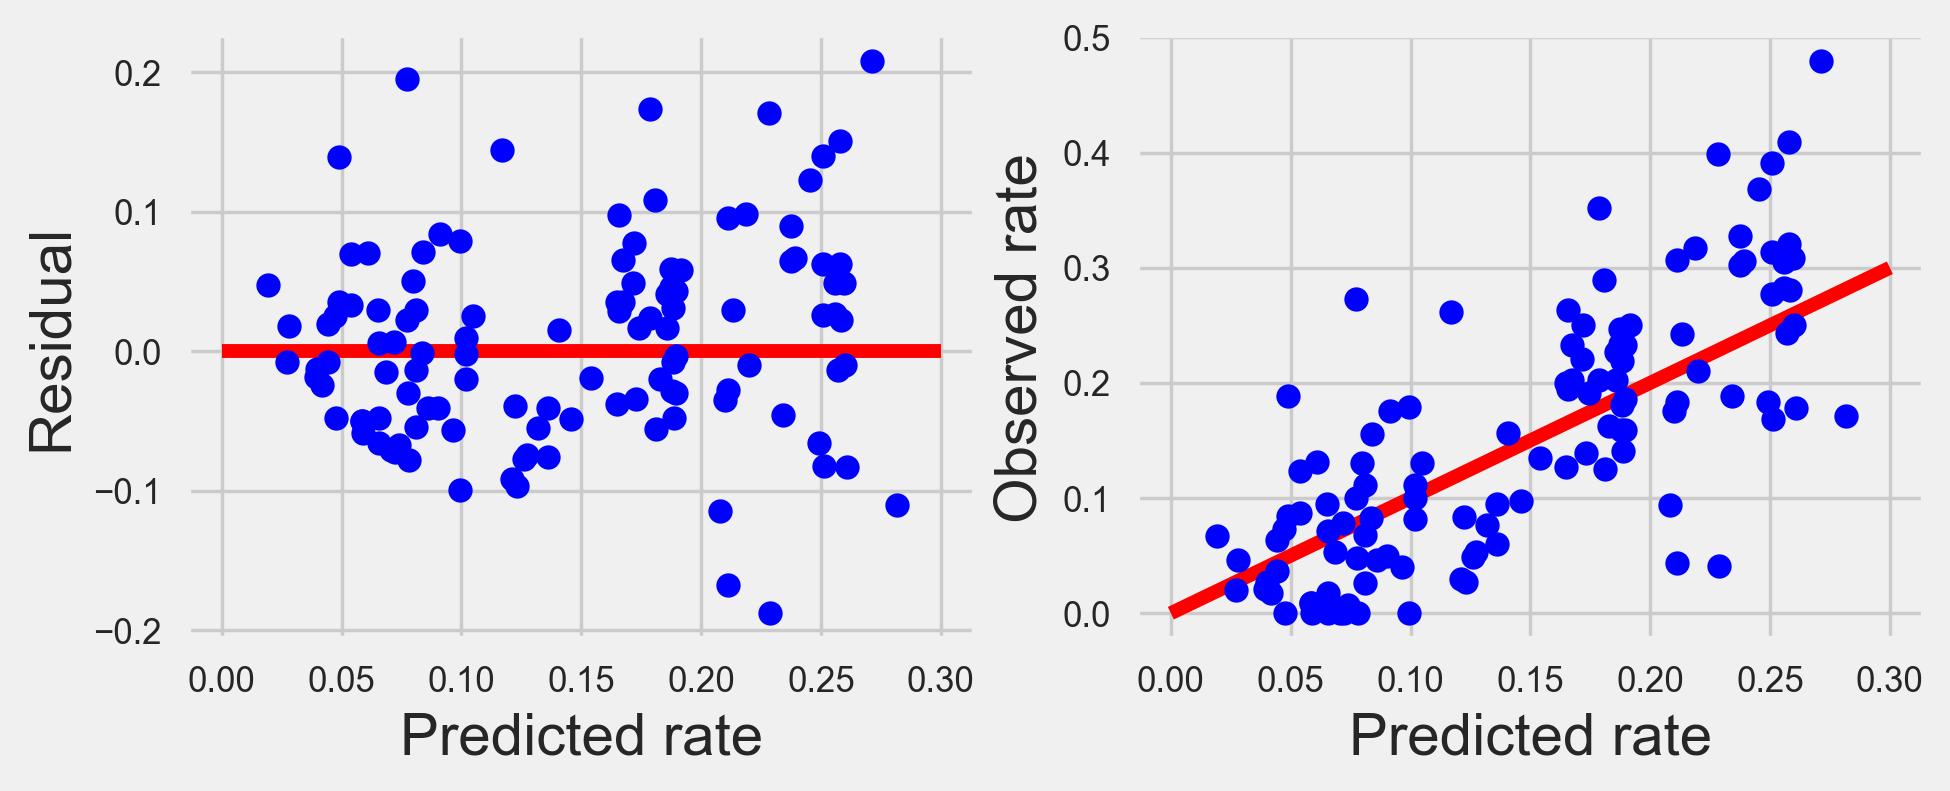

In [230]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test_scaled)
resid = [true-pred for true, pred in zip(y_test0, lasso_pred)]
plt.figure(dpi=250,figsize=(8,3))
plt.subplot(1,2,1)
plt.plot([0,.3],[0,0],"r")
plt.plot(lasso_pred,resid,"ob")
plt.xlabel("Predicted rate")
plt.ylabel("Residual")

plt.subplot(1,2,2)
plt.plot([0,.3],[0,.3],"r")
plt.plot(lasso_pred,y_test0, "ob")
plt.xlabel("Predicted rate")
plt.ylabel("Observed rate");

In [232]:
from scipy.stats import normaltest

In [261]:
normaltest(resid)

NormaltestResult(statistic=3.049772812795532, pvalue=0.2176457786290947)

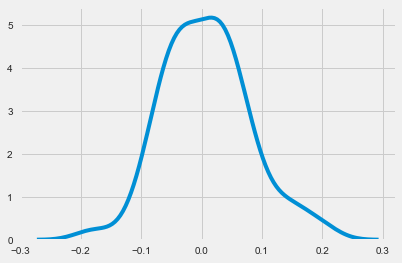

In [259]:
sns.kdeplot(resid);

## finish times

In [ ]:
df["finish_times"]=df["finish_times"].transform(np.array)

In [ ]:
df["med_finish"]=df["finish_times"].transform(lambda x: x[int(len(x)/2)])

In [ ]:
df["normalized_times"]=df["finish_times"]/df["med_finish"]

In [ ]:
df.drop("normalixed_times", inplace=True)

In [ ]:
plt.figure(dpi=150)
for _, race in df.sample(n=10, random_state=42).iterrows():
    n = len(race["normalized_times"])
    xs = [i/n for i in range(n)]
    ys = race["normalized_times"]
    plt.plot(xs,ys)
plt.xlabel("rank / n")
plt.ylabel("finish time / mean")
plt.title("Spread of relative finish time per race")
plt.xlim(0,0.5)
plt.ylim(0.9,1.0)

In [ ]:
df.normalized_times.head()
#plt.hist([1,1,1,1,1,3,2,3,2,3,4,2,2,3,2,1,3,1,4]);

In [ ]:
df.normalized_times.transform(pd.Series).head()

In [ ]:
for k in sorted(list(set(df["season"].values))):
    print(k,df["season"].value_counts()[k])

In [ ]:
df["field_mean"] = df.groupby(["ladies", "location", "event"])["med_finish"].head()

In [ ]:
len(df[df["field_mean"] != df["med_finish"]])

In [ ]:

region_dnfs = df.groupby("region")["dnf_rate"].mean()
plt.figure(dpi=200)
plt.barh(region_dnfs.index, region_dnfs.values)
plt.xlabel("mean dnf_rate")
plt.title("dnf rate by country")